# Introduction

Three population replicator dynamics for activation signaling game.

# Game and utilities 

Prior probability function

In [1]:
from scipy.special import beta as beta_func
from scipy.misc import comb
def beta_binomial(n, alpha, beta):
    return np.matrix([comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta) for k in range(n)])
def beta_binomial_expectation(prior):
    return sum([prior[i]*i/len(prior) for i in range(len(prior))])

In [2]:
import numpy as np
# Define the utility functions
def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
    #return 1 - abs(action - state - (1-state)*b)
def U_R(state, action):
    return 1 - (action - state)**2
# Define functions to map integers to interval [0,1]
def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

In [3]:
def calc_EX(Y, Z, n):
    EX = []
    for i in range(n):
        m1 = [prior[0,j]*(A*Y.transpose())[j,0] for j in range(i)]
        m2 = [prior[0,j]*(A*Z.transpose())[j,0] for j in range(i,n)]
        EX.append(sum(m1) + sum(m2))
    return np.matrix(EX)

In [4]:
def cond_prob(X,n):
    p_m1_t = [prior[0,j]*np.sum(X[0,j+1:n]) for j in range(n)]
    p_m2_t = [prior[0,j]*np.sum(X[0,0:j+1]) for j in range(n)]
    p_m1 = sum([X[0,j]*np.sum(prior[0,0:j]) for j in range(n)])
    p_m2 = sum([X[0,j]*np.sum(prior[0,j:n]) for j in range(n)])
    #
    p_t_m1 = np.matrix(np.divide(p_m1_t,p_m1))
    p_t_m2 = np.matrix(np.divide(p_m2_t,p_m2))
    return p_t_m1, p_t_m2

#p_t_m1, p_t_m2 = cond_prob(X0,10)

In [5]:
def calc_EYZ(X, n):
    p_t_m1, p_t_m2 = cond_prob(X,n)
    EY = p_t_m1*B
    EZ = p_t_m2*B
    return EY, EZ

#calc_EYZ(X0, 10)

# Simulations

In [6]:
# Signaling system to integrate over
def signaling(Y_init, t):
    # Unpack initial position
    n = len(Y_init)/3
    X = np.matrix(Y_init[0:n])
    Y = np.matrix(Y_init[n:2*n])
    Z = np.matrix(Y_init[2*n:])
    # Calculate sender expected utility 
    E_X = calc_EX(Y, Z, n)
    E_X_bar = X*E_X.transpose()
    X_d = np.multiply(X, E_X - E_X_bar)
    # Calculate receiver expected utility
    E_Y, E_Z = calc_EYZ(X, n)
    E_Y_bar = Y*E_Y.transpose()
    Y_d = np.multiply(Y, E_Y - E_Y_bar)
    E_Z_bar = Z*E_Z.transpose()
    Z_d = np.multiply(Z, E_Z - E_Z_bar)
    # Return system of ODEs
    return X_d.tolist()[0] + Y_d.tolist()[0] + Z_d.tolist()[0]

Define everything so that each run can be self-contained.

In [7]:
timesteps = np.linspace(0,2000, num=100)
prior = beta_binomial(100, 1, 2)
number = 100
b = .35
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])

X0 = beta_binomial(100, 2,20)
#Z0 = beta_binomial(100, 10,2)
Y0 = beta_binomial(100, 60/7.0, 20)
Z0 = beta_binomial(100, 16, 4)
#Y0 = beta_binomial(100, 4,8)
Y_init = X0.tolist()[0] + Y0.tolist()[0] + Z0.tolist()[0]

Solve the system of odes numerically

In [7]:
from scipy.integrate import odeint

In [8]:
import time

In [103]:
timesteps = np.linspace(0,60, num=375)

In [98]:
start = time.time()
timesteps = np.linspace(0,2000, num=100)
Y_result = odeint(signaling, Y_init, timesteps)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)

Visualize the system

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

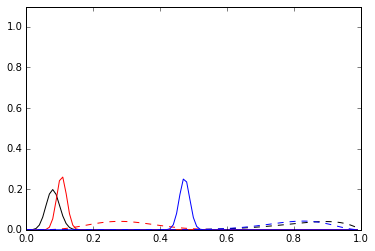

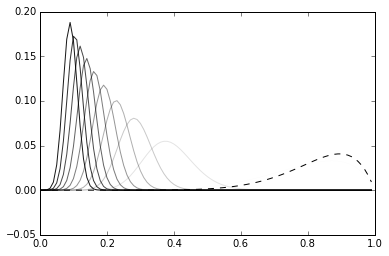

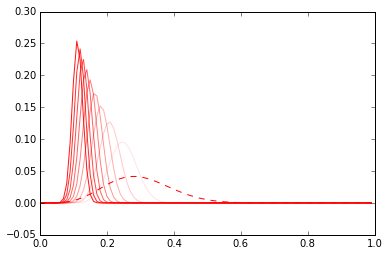

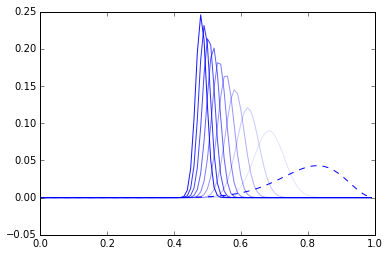

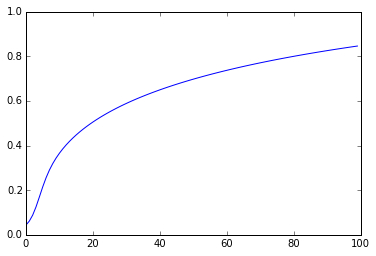

In [105]:
X_sol = Y_result[:,0:number]
Y_sol = Y_result[:,number:2*number]
Z_sol = Y_result[:,2*number:]
states = [item/float(number) for item in range(number)]
plt.plot(states, X_sol[0,:], 'k--')
plt.plot(states, X_sol[-1,:], 'k-')
plt.plot(states, Y_sol[0,:], 'r--')
plt.plot(states, Y_sol[-1,:], 'r-')
plt.plot(states, Z_sol[0,:], 'b--')
plt.plot(states, Z_sol[-1,:], 'b-')
plt.ylim(0,1.1)
plt.show()
for i in range(1,len(timesteps), len(timesteps)/10):
    plt.plot(states, X_sol[i,:], color='k', alpha=(i/float(len(timesteps))))
plt.plot(states, X_sol[0,:], 'k--')
plt.show()
for i in range(1,len(timesteps), len(timesteps)/10):
    plt.plot(states, Y_sol[i,:], color='r', alpha=(i/float(len(timesteps))))
plt.plot(states, Y_sol[0,:], 'r--')    
plt.show()
for i in range(1,len(timesteps), len(timesteps)/10):
    plt.plot(states, Z_sol[i,:], color='b', alpha=(i/float(len(timesteps))))
plt.plot(states, Z_sol[0,:], 'b--')
plt.show()
m2_sol = [sum([line[j]*np.sum(prior[0,j:number]) for j in range(number)]) for line in X_sol]
plt.plot(m2_sol)
plt.ylim(0,1)
plt.show()

#  Discretized version

In [12]:
from scipy.integrate import odeint
from scipy.optimize import minimize

## Continuous-time replicator dynamics

In [204]:
def signaling(X_init, t):
    # Unpack the position vector
    X = np.reshape(np.matrix([X_init[0:6]]), (3,2))
    Y = np.reshape(np.matrix([X_init[6:]]), (2,3))
    # Unpack bias parameter and construct payoff matrices ***this may be kicked up
    #b = param[0]
    #A = np.matrix([[1-b, b, 0],\
    #     [0, 1-b, b],\
    #     [0, 0, 1]])
    #B = np.matrix([[1, 0, 0],\
    #     [0, 1, 0],\
    #     [0, 0, 1]])
    #########################
    # Sender expected utility
    E_X = A * Y.T
    # Average sender expected utility
    X_bar = (((A * Y.T) * X.T).diagonal()).T
    # Excess payoff over average
    X_hat = np.subtract(E_X, X_bar)
    # Differential
    X_diff = np.multiply(X0, X_hat).ravel().tolist()[0]
    #########################
    # Receiver expected utility
    # Prior
    P = np.repeat(prior, 2, axis=0) # **can kick this up
    C = np.divide(np.multiply(P.transpose(), X0), (P * X0)[0])
    # Receiver expected utility
    E_Y = (B.T * C).T
    # Average receiver expected utility
    Y_bar = np.sum(np.multiply(Y0, (B.transpose() * C).transpose()), axis=1)
    # Excess payoff over average
    Y_hat = np.subtract(E_Y, Y_bar)
    # Differential
    Y_diff = np.multiply(Y0, Y_hat).ravel().tolist()[0]
    # Return system of ODEs
    return X_diff + Y_diff

## Discrete-time replicator dynamics

In [4]:
def discrete_time_replicator_dynamics(n_steps, X, Y, A, B, P):
    """Calculate the discrete-time replicator dynamics for"""
    # Get the number of states, signals, and actions
    X_nrow = X.shape[0]
    X_ncol = X.shape[1]
    Y_nrow = Y.shape[0] # Same as X_ncol
    Y_ncol = Y.shape[1] # Often, but not necessarily, the same as X_nrow
    # Create empty arrays to hold the population states over time
    X_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    Y_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    # Set the initial state
    X_t[0,:] = X.ravel()
    Y_t[0,:] = Y.ravel()
    # Iterate forward over (n-1) steps
    for i in range(1,n_steps):
        # Get the previous state
        X_prev = X_t[i-1,:].reshape(X_nrow, X_ncol)
        Y_prev = Y_t[i-1,:].reshape(Y_nrow, Y_ncol)
        # Calculate the scaling factors
        E_X = A * Y_prev.T
        X_bar = (((A * Y_prev.T) * X_prev.T).diagonal()).T
        X_hat = E_X / X_bar
        # 
        C = np.divide(np.multiply(P.T, X_prev), (P * X_prev)[0])
        E_Y = (B.T * C).T
        Y_bar = ((E_Y*Y_prev.T).diagonal()).T
        Y_hat = np.divide(E_Y, Y_bar)
        # Calculate next states
        X_t[i,:] = np.multiply(X_prev, X_hat).ravel()
        Y_t[i,:] = np.multiply(Y_prev, Y_hat).ravel()
    return X_t, Y_t

In [253]:
start = time.time()
timesteps = np.linspace(0,2000, num=100)
X_sol, Y_sol = discrete_time_replicator_dynamics(5000, X0, Y0, A, B, P)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)

00:05


In [224]:
print res_TNC1000.x

[  1.          26.78284889   2.67202438  35.46773145  20.19355847
  27.32004879   0.27527799]


In [55]:
# Define number of states: 20, 4, 4, 20, 25, 4, .2
number = 200
# Define prior probability
prior = beta_binomial(number, 1, 2)
P = np.repeat(prior, 2, axis=0)
# Define payoff matrices
b = .4
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
# Define sender population
X0_m2 = beta_binomial(number, 4, 20)
X0_m1 = 1 - X0_m2
X0 = np.vstack((X0_m1, X0_m2)).T
# Define receiver population
Y0 = np.vstack((beta_binomial(number, 2, 15), beta_binomial(number, 20, 20)))

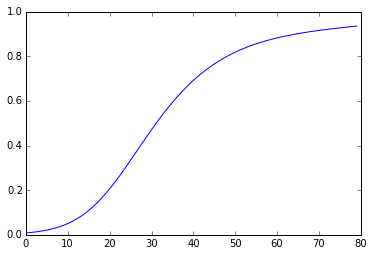

In [56]:
X_sol, Y_sol = discrete_time_replicator_dynamics(80, X0, Y0, A, B, P)
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
plt.plot(m2_sol, 'b')
plt.ylim(0,1)
plt.show()

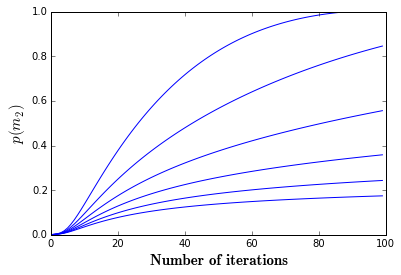

In [27]:
hfont = {'fontname':'Helvetica'}
for i in np.linspace(0,.8,num=6):
    # Define payoff matrices
    b = i
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    X_sol, Y_sol = discrete_time_replicator_dynamics(100, X0, Y0, A, B, P)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    plt.plot(m2_sol, 'b')
plt.ylim(0,1)
plt.xlabel('Number of iterations', fontsize=15, **hfont)
plt.ylabel(r'$p(m_2)$', fontsize=15, **hfont)
plt.savefig("replicator-multiple-b.eps", format='eps', dpi=1000)
plt.show()

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


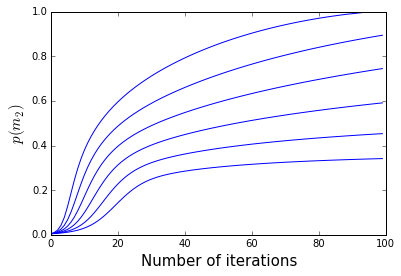

In [9]:
hfont = {'fontname':'Helvetica'}
for i in np.linspace(0,.8,num=6):
    # Define payoff matrices
    b = i
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    X_sol, Y_sol = discrete_time_replicator_dynamics(100, X0, Y0, A, B, P)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    plt.plot(m2_sol, 'b')
plt.ylim(0,1)
plt.xlabel('Number of iterations', fontsize=15, **hfont)
plt.ylabel(r'$p(m_2)$', fontsize=15, **hfont)
plt.savefig("replicator-multiple-b.eps", format='eps', dpi=1000)
plt.show()

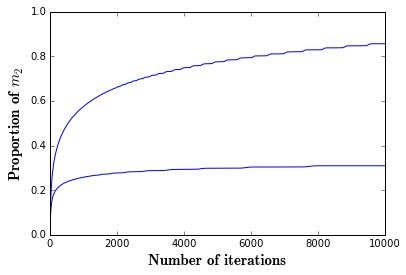

In [651]:
hfont = {'fontname':'Helvetica'}
for i in [0, .25]:
    # Define payoff matrices
    b = i
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    X_sol, Y_sol = discrete_time_replicator_dynamics(10000, X0, Y0, A, B, P)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    plt.plot(m2_sol, 'b')
plt.ylim(0,1)
plt.xlabel('Number of iterations', fontsize=15, **hfont)
plt.ylabel(r'Proportion of $m_2$', fontsize=15, **hfont)
plt.savefig("replicator-compare-b.eps", format='eps', dpi=1000)
plt.show()

Fitting the 

In [31]:
import pandas as pd
import numpy as np
df1 = pd.read_csv("./first_curve_data.csv")

In [29]:
def loss_first(params):
    """Objective function for IBR-like model"""
    # Unpack the paramters
    a_x, b_x = params[0:2]
    a_y1, b_y1 = params[2:4]
    a_y2, b_y2 = params[4:6]
    b = params[6]
    k=1 # Change this to alter scaling parameter
    # Construct initial states
    # Number of states and actions
    number = 200
    # Define prior probability
    prior = beta_binomial(number, 1, 2)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, a_x, b_x)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, a_y1, b_y1), beta_binomial(number, a_y2, b_y2)))
    # Iterate through the discrete-time replicator dynamics
    X_sol, Y_sol = discrete_time_replicator_dynamics(k*375 + 1, X0, Y0, A, B, P)
    # Get p(m_2) over time
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    # Get data indices
    indices = np.subtract(df1.year.unique(), min(df1.year))
    # Get count of tokens for indices
    counts = df1.groupby('year').size() #.loc[index + 1125]
    # Get count of value==1 for indices
    values = df1.groupby('year').aggregate(np.sum)
    # Initialize RSS value
    RSS = 0
    # Loop over indices
    for index in indices:
        zero_count = counts.loc[index + min(df1.year)] - values.loc[index + min(df1.year), 'value']
        one_count = values.loc[index + min(df1.year), 'value']
        #
        RSS += zero_count*(0 - m2_sol[index])**2 + one_count*(1 - m2_sol[index])**2
    return RSS

In [ ]:
guess = np.array([20, 4, 4, 20, 25, 4, .2])
bnds = ((1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (0,1))

In [32]:
start = time.time()
#
res_BFGS = minimize(loss_first, x0=guess, method="L-BFGS-B", bounds=bnds)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "BFGS:", "%02d:%02d" % (m, s)
res_TNC = minimize(loss_first, x0=guess, method="TNC", bounds=bnds)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "TNC:", "%02d:%02d" % (m, s)
res_COBYLA = minimize(loss_first, x0=guess, method="COBYLA", bounds=bnds)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "COBYLA:", "%02d:%02d" % (m, s)
res_SLSQP = minimize(loss_first, x0=guess, method="SLSQP", bounds=bnds)
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "SLSQP:", "%02d:%02d" % (m, s)

BFGS: 10:47
TNC: 16:19
COBYLA: 22:27
SLSQP: 33:39


/home/cahern/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:397: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


In [694]:
guess = np.array([20, 4, 4, 20, 25, 4, .2])
bnds = ((1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (0,1))
#
start = time.time()
#
res_SQLSP = minimize(loss_first, x0=guess, method="SLSQP", bounds=bnds)
#
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)
print res

11:24
  status: 2
    nfev: 1000
   maxcv: 0.0
 success: False
     fun: 606.86183282911406
       x: array([ 20.22780341,   4.77530051,   4.22757666,  21.1764925 ,
        24.95578317,   5.59476116,   0.50493047])
 message: 'Maximum number of function evaluations has been exceeded.'


In [41]:
print res_TNC

  status: 3
 success: False
    nfev: 100
     fun: 590.27890021759231
       x: array([  4.68799838,  32.7174453 ,   1.20111968,  28.10553768,
        14.52964133,  33.98578775,   0.21432972])
 message: 'Max. number of function evaluations reached'
     jac: array([ 25.94805437,  -2.49547156, -32.84312697,   0.47496087,
         3.14109911,  -1.08192353,  23.38670129])
     nit: 15


In [7]:
# Start with initial guesses and bounds
guess = np.array([20, 4, 4, 20, 25, 4, .2])
bnds = ((1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (1, 200), (0,1))
# Start timer
start = time.time()
# Solve for various numbers of iterations
res_TNC100 = minimize(loss_first, x0=guess, method="TNC", bounds=bnds, options={"maxiter" : 100, "disp" : True})
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)
res_TNC200 = minimize(loss_first, x0=guess, method="TNC", bounds=bnds, options={"maxiter" : 200, "disp" : True})
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)
res_TNC500 = minimize(loss_first, x0=guess, method="TNC", bounds=bnds, options={"maxiter" : 500, "disp" : True})
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print "%02d:%02d" % (m, s)

NameError: name 'time' is not defined

In [145]:
res_TNC1000 = minimize(loss_first, x0=guess, method="TNC", bounds=bnds, options={"maxiter" : 1000, "disp" : True})

In [149]:
res_TNC1000.x

array([  1.        ,  26.78284889,   2.67202438,  35.46773145,
        20.19355847,  27.32004879,   0.27527799])

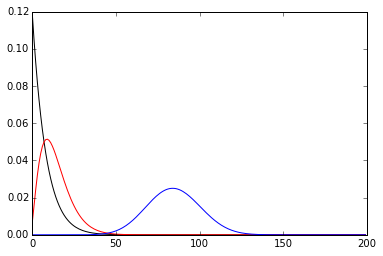

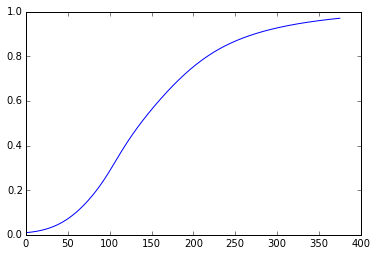

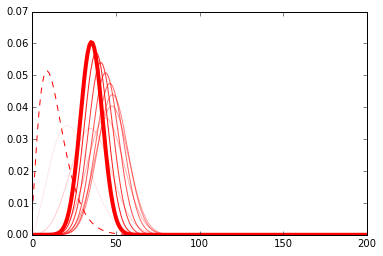

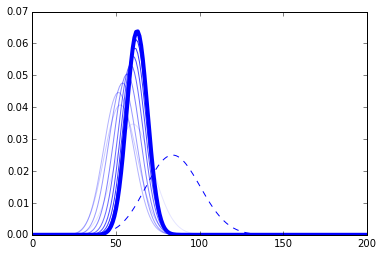

In [270]:
res = res_TNC1000
b = res.x[6]
# Define payoff matrices
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
# Define sender population
X0_m2 = beta_binomial(number, res.x[0], res.x[1])
X0_m1 = 1 - X0_m2
X0 = np.vstack((X0_m1, X0_m2)).T
# Define receiver population
Y0 = np.vstack((beta_binomial(number, res.x[2], res.x[3]), beta_binomial(number, res.x[4], res.x[5])))
# Visualize initial state
plt.plot(X0[:,1].tolist(), 'k')
plt.plot(Y0[0,:].tolist()[0], 'r')
plt.plot(Y0[1,:].tolist()[0],'b')
plt.show()
# Iterate through the discrete-time replicator dynamics
X_sol, Y_sol = discrete_time_replicator_dynamics(375 + 1, X0, Y0, A, B, P)
#X_sol, Y_sol = discrete_time_replicator_dynamics(375 + 1, X0, Y0, A, B, P)
# Get p(m_2) over time
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]

plt.plot(m2_sol, 'b')
#plt.plot([1125 + item for item in range(376)], m2_sol, 'b')
plt.show()
for i in range(1,timesteps, timesteps/10):
    plt.plot(Y_sol[i,:200], color='r', alpha=(i/float(timesteps)))
plt.plot(Y_sol[0,:200], 'r--')
plt.plot(Y_sol[-1,:200], 'r', linewidth=4)
plt.show()
#for line in Y_sol[:,:200]:
#    plt.plot(line)
#plt.show()
for i in range(1,timesteps, timesteps/10):
    plt.plot(Y_sol[i,200:], color='b', alpha=(i/float(timesteps)))
plt.plot(Y_sol[0,200:], 'b--')
plt.plot(Y_sol[-1,200:], 'b', linewidth=4)
plt.show()
#for line in Y_sol[:,200:]:
#    plt.plot(line)
#plt.show()

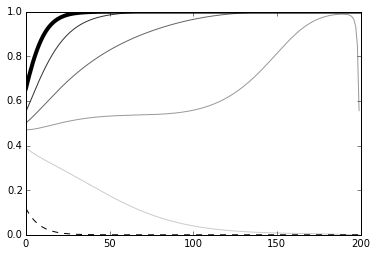

[1126, 1201, 1276, 1351, 1426]


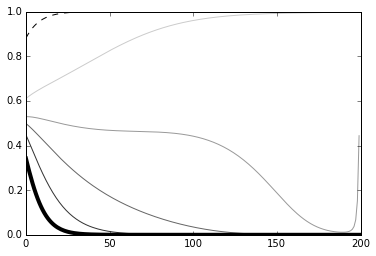

In [281]:
for i in range(1,timesteps, timesteps/5):
    plt.plot(X_sol[i,1::2], color='k', alpha=(i/float(timesteps)))
    
plt.plot(X_sol[0,1::2], 'k--')
plt.plot(X_sol[-2,1::2], 'k', linewidth=4)
plt.show()
print [item + 1125 for item in range(1, timesteps, timesteps/5)]
for i in range(1,timesteps, timesteps/5):
    plt.plot(X_sol[i,0::2], color='k', alpha=(i/float(timesteps)))
    #plt.text(10*i, X_sol[i,0::2],'matplotlib')
plt.plot(X_sol[0,0::2], 'k--')
plt.plot(X_sol[-1,0::2], 'k', linewidth=4)
plt.show()

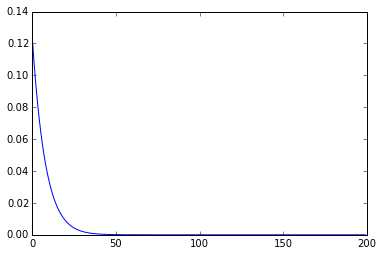

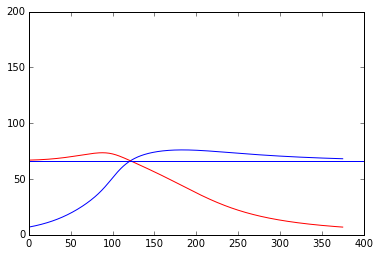

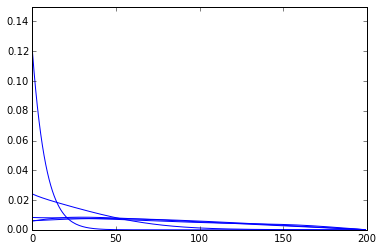

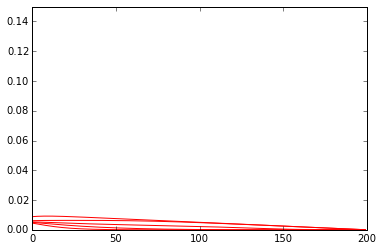

In [221]:
line = X_sol[0,1::2]
p_m2 = prior.dot(line)[0,0]
#print line.shape
#print prior.shape
#print line[0]*prior[0,0]
plt.plot((np.multiply(line, prior)/prior.dot(line)[0,0]).tolist()[0])
plt.show()
#(np.multiply(line, prior)/prior.dot(line)[0,0]).shape
plt.plot([(np.matrix(range(200)) * (np.multiply(line, prior)/prior.dot(line)[0,0]).T)[0,0] for line in X_sol[:,1::2]], 'b')
plt.plot([(np.matrix(range(200)) * (np.multiply(line, prior)/prior.dot(line)[0,0]).T)[0,0] for line in X_sol[:,0::2]], 'r')
plt.ylim(0,200)
plt.axhline(y=66)
plt.show()

for i in range(1,timesteps, timesteps/5):
#for line in X_sol[0:,1::2]:
    plt.plot((np.multiply(X_sol[i,1::2], prior)/prior.dot(X_sol[i,1::2])[0,0]).tolist()[0], 'b')
plt.ylim(0,.15)
plt.show()
for i in range(1,timesteps, timesteps/5):
#for line in X_sol[0:,1::2]:
    plt.plot((np.multiply(X_sol[i,0::2], prior)/prior.dot(X_sol[0,0::2])[0,0]).tolist()[0], 'r')
plt.ylim(0,.15)
plt.show()



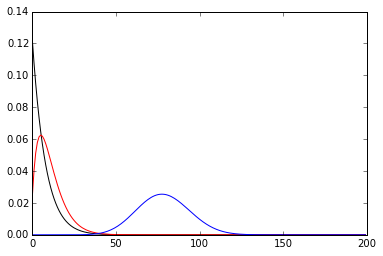

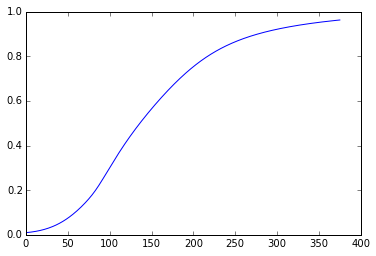

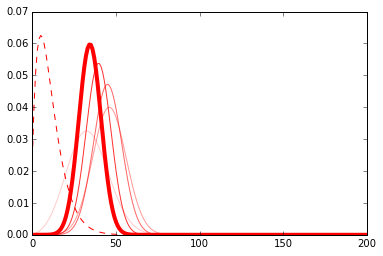

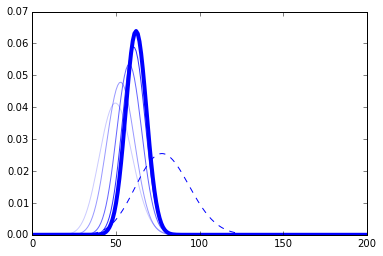

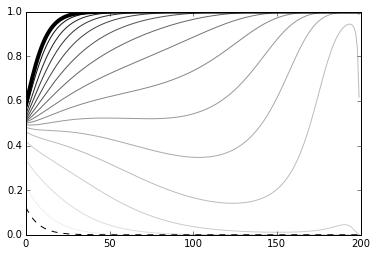

In [222]:
res = res_TNC500
b = res.x[6]
# Define payoff matrices
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
# Define sender population
X0_m2 = beta_binomial(number, res.x[0], res.x[1])
X0_m1 = 1 - X0_m2
X0 = np.vstack((X0_m1, X0_m2)).T
# Define receiver population
Y0 = np.vstack((beta_binomial(number, res.x[2], res.x[3]), beta_binomial(number, res.x[4], res.x[5])))
# Visualize initial state
plt.plot(X0[:,1].tolist(), 'k')
plt.plot(Y0[0,:].tolist()[0], 'r')
plt.plot(Y0[1,:].tolist()[0],'b')
plt.show()
# Iterate through the discrete-time replicator dynamics
X_sol, Y_sol = discrete_time_replicator_dynamics(375 + 1, X0, Y0, A, B, P)
#X_sol, Y_sol = discrete_time_replicator_dynamics(375 + 1, X0, Y0, A, B, P)
# Get p(m_2) over time
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
plt.plot(m2_sol, 'b')
#plt.plot([1125 + item for item in range(376)], m2_sol, 'b')
plt.show()
for i in range(1,timesteps, timesteps/5):
    plt.plot(Y_sol[i,:200], color='r', alpha=(i/float(timesteps)))
plt.plot(Y_sol[0,:200], 'r--')
plt.plot(Y_sol[-1,:200], 'r', linewidth=4)
plt.show()
#for line in Y_sol[:,:200]:
#    plt.plot(line)
#plt.show()
for i in range(1,timesteps, timesteps/5):
    plt.plot(Y_sol[i,200:], color='b', alpha=(i/float(timesteps)))
plt.plot(Y_sol[0,200:], 'b--')
plt.plot(Y_sol[-1,200:], 'b', linewidth=4)
plt.show()
#for line in Y_sol[:,200:]:
#    plt.plot(line)
#plt.show()
for i in range(1,timesteps, timesteps/15):
    plt.plot(X_sol[i,1::2], color='k', alpha=(i/float(timesteps)))
plt.plot(X_sol[0,1::2], 'k--')
plt.plot(X_sol[-2,1::2], 'k', linewidth=4)
plt.show()

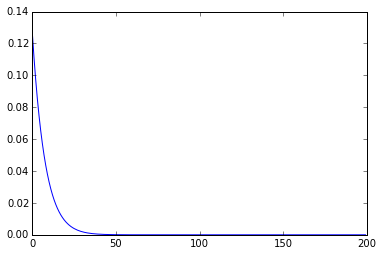

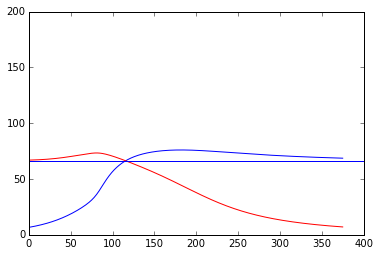

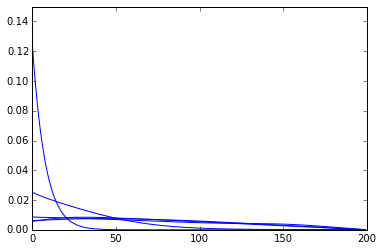

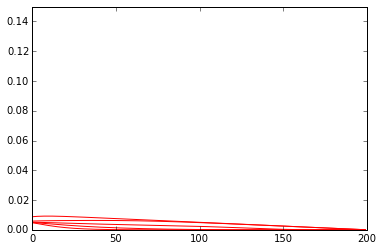

In [223]:
line = X_sol[0,1::2]
p_m2 = prior.dot(line)[0,0]
#print line.shape
#print prior.shape
#print line[0]*prior[0,0]
plt.plot((np.multiply(line, prior)/prior.dot(line)[0,0]).tolist()[0])
plt.show()
#(np.multiply(line, prior)/prior.dot(line)[0,0]).shape
plt.plot([(np.matrix(range(200)) * (np.multiply(line, prior)/prior.dot(line)[0,0]).T)[0,0] for line in X_sol[:,1::2]], 'b')
plt.plot([(np.matrix(range(200)) * (np.multiply(line, prior)/prior.dot(line)[0,0]).T)[0,0] for line in X_sol[:,0::2]], 'r')
plt.ylim(0,200)
plt.axhline(y=66)
plt.show()

for i in range(1,timesteps, timesteps/5):
#for line in X_sol[0:,1::2]:
    plt.plot((np.multiply(X_sol[i,1::2], prior)/prior.dot(X_sol[i,1::2])[0,0]).tolist()[0], 'b')
plt.ylim(0,.15)
plt.show()
for i in range(1,timesteps, timesteps/5):
#for line in X_sol[0:,1::2]:
    plt.plot((np.multiply(X_sol[i,0::2], prior)/prior.dot(X_sol[0,0::2])[0,0]).tolist()[0], 'r')
plt.ylim(0,.15)
plt.show()

